In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import scipy.stats as stats
import os
import warnings
import random
from matplotlib.colors import LogNorm
import statsmodels.api as sm
from matplotlib.patches import Patch
meta = pd.read_csv(r'S:\ASAP_Imaging_Data\Main_Survey\oligomers_in_cells_additional_data\metadata.csv')
warnings.filterwarnings('ignore')

# Define which cell types you want to have analysed here
patient_types = ['HC_analysis', 'PD_analysis']

rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14

In [16]:
da = pd.read_csv(r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells\frontal\microglia\HC_analysis\single_cell_coincidence_mincellsize_2000_photonthreshold_0_photons_combined_threshold_percentile_0_k_4_outliersremoved_abovethreshold.csv')
db = pd.read_csv(r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells\frontal\microglia\PD_analysis\single_cell_coincidence_mincellsize_2000_photonthreshold_0_photons_combined_threshold_percentile_0_k_4_outliersremoved_abovethreshold.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'S:\\ASAP_Imaging_Data\\Main_Survey\\20241105_oligomers_in_cells\\frontal\\microglia\\HC_analysis\\single_cell_coincidence_mincellsize_2000_photonthreshold_0_photons_combined_threshold_percentile_0_k_4_outliersremoved_abovethreshold.csv'

In [14]:
pd_ids = ['PD0822', 'PD0612','PD0086','PD0687','PD0596', 'PD0590', 'PD0913','PD0109', 'PD0980','PD0969','PD0945','PD0779', 'PD0022','PD0917']
hc_ids = ['C030','C043','C046','C073','C074','C075','C076','PDC022','PDC029','PDC034','PDC035','PDC085','PDC087']

def process_data(df_pd, df_hc, cell_type, region):
    if region == 'substantiaNigra':
        df_pd['id'] = df_pd['image_filename'].str.slice(103,111)
        df_hc['id'] = df_hc['image_filename'].str.slice(103,111)
        df_hc['donorid'] = df_hc['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
        df_pd['donorid'] = df_pd['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
    else:
        df_pd['id'] = df_pd['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['id'] = df_hc['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['donorid'] = df_hc['id'].map(meta.set_index('R_S_ID')['donorid'])
        df_pd['donorid'] = df_pd['id'].map(meta.set_index('R_S_ID')['donorid'])

    df_pd['celldensity'] = df_pd['n_puncta_in_cell']/df_pd['area/um3']
    df_hc['celldensity'] = df_hc['n_puncta_in_cell']/df_hc['area/um3']

    individual_hc = df_hc.groupby('donorid')['celldensity'].agg(['mean', 'std']).reset_index()
    individual_pd = df_pd.groupby('donorid')['celldensity'].agg(['mean', 'std']).reset_index()

    # Create separate dictionaries for PD and HC
    out_pd = {}
    out_hc = {}
    
    for _, row in individual_pd.iterrows():
        out_pd[row['donorid']] = {'pd_mean': row['mean'], 'pd_std': row['std']}
    
    for _, row in individual_hc.iterrows():
        out_hc[row['donorid']] = {'hc_mean': row['mean'], 'hc_std': row['std']}

    return out_hc, out_pd


In [15]:
out_hc, out_pd = process_data(da, db, 'microglia', 'frontal')

KeyError: 'area/um3'

In [5]:
# 20250115: Computing the data for varying int thresholds on the new int-thresholded datasheets with percentile qualifier
PD_over_HC = []
folder = r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells'
regions = [r for r in os.listdir(folder) if r != '.DS_Store']
cell_types = ['microglia']                   ## Used for troubleshooting
regions = ['caudate', 'cingulate', 'frontal', 'parietal']                                  ## Used for troubleshooting
HC_finished = []
PD_finished = []

def extract_number(filename):
    prefix = "threshold_percentile_"
    start = filename.find(prefix) + len(prefix)
    end = filename.find("_k_4_", start)
    return float(filename[start:end])

int_threshs = np.arange(0, 100, 5)  # Define the thresholds used to create the datasheets in the folders.

for region in regions:
    for i, cell_type in enumerate(cell_types):
        if os.path.isdir(os.path.join(folder, region, cell_type, patient_types[1])):
            PD_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[1]))
            PD_data_files = np.sort([x for x in PD_data_files if '_mincellsize_2000_' in x and 'k_4_outliersremoved' in x and '_combined_' in x and 'cell_protein_load' not in x and 'percentile' in x])
            numbers = np.array([extract_number(file) for file in PD_data_files])
            sorted_indices = np.argsort(numbers)
            PD_data_files = PD_data_files[sorted_indices]
            PD_data_files = [file for file in PD_data_files if extract_number(file) in int_threshs]
            if len(PD_data_files) == len(int_threshs):
                PD_data = {}
                for file in PD_data_files:
                    PD_data[file] = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[1], file))
            else:
                continue

            HC_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[0]))
            HC_data_files = np.sort([x for x in HC_data_files if '_mincellsize_2000_' in x and 'k_4_outliersremoved' in x and '_combined_' in x and 'cell_protein_load' not in x and 'percentile' in x])
            numbers = np.array([extract_number(file) for file in HC_data_files])
            sorted_indices = np.argsort(numbers)
            HC_data_files = HC_data_files[sorted_indices]
            HC_data_files = [file for file in HC_data_files if extract_number(file) in int_threshs]
            if len(HC_data_files) == len(int_threshs):
                HC_data = {}
                for file in HC_data_files:
                    HC_data[file] = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[0], file))
            else:
                continue

            for key, int_threshold in enumerate(int_threshs):
                out_hc, out_pd = process_data(PD_data[PD_data_files[key]], HC_data[HC_data_files[key]], cell_type, region)
                # Process HC data
                for donorid, value in out_hc.items():
                    entry = {
                        'donorid': donorid,
                        'cell_type': cell_type,
                        'region': region,
                        'int_threshold': int_threshold,
                        'hc_mean': value['hc_mean'],
                        'hc_std': value['hc_std']
                    }
                    HC_finished.append(entry)
                # Process PD data
                for donorid, value in out_pd.items():
                    entry = {
                        'donorid': donorid,
                        'cell_type': cell_type,
                        'region': region,
                        'int_threshold': int_threshold,
                        'pd_mean': value['pd_mean'],
                        'pd_std': value['pd_std']
                    }
                    PD_finished.append(entry)

df_hc = pd.DataFrame([entry for entry in HC_finished if isinstance(entry, dict)])
df_pd = pd.DataFrame([entry for entry in PD_finished if isinstance(entry, dict)])

# Create a new column "LP" based on conditions
df_hc['LP'] = None
df_pd['LP'] = None
df_hc.loc[df_hc['region'].isin(['parietal', 'frontal']), 'LP'] = 'No Lewy pathology'
df_hc.loc[df_hc['region'].isin(['cingulate','temporal', 'parahippocampal']), 'LP'] = 'Mild Lewy pathology'
df_hc.loc[df_hc['region'].isin(['putamen', 'caudate','substantiaNigra']), 'LP'] = 'Moderate-severe Lewy pathology'
df_pd.loc[df_pd['region'].isin(['parietal', 'frontal']), 'LP'] = 'No Lewy pathology'
df_pd.loc[df_pd['region'].isin(['cingulate','temporal', 'parahippocampal']), 'LP'] = 'Mild Lewy pathology'
df_pd.loc[df_pd['region'].isin(['putamen', 'caudate','substantiaNigra']), 'LP'] = 'Moderate-severe Lewy pathology'

KeyError: 'region'

In [ ]:
df_hc = df_hc[df_hc['int_threshold'] == 75].reset_index()
df_pd = df_pd[df_pd['int_threshold'] == 75].reset_index()

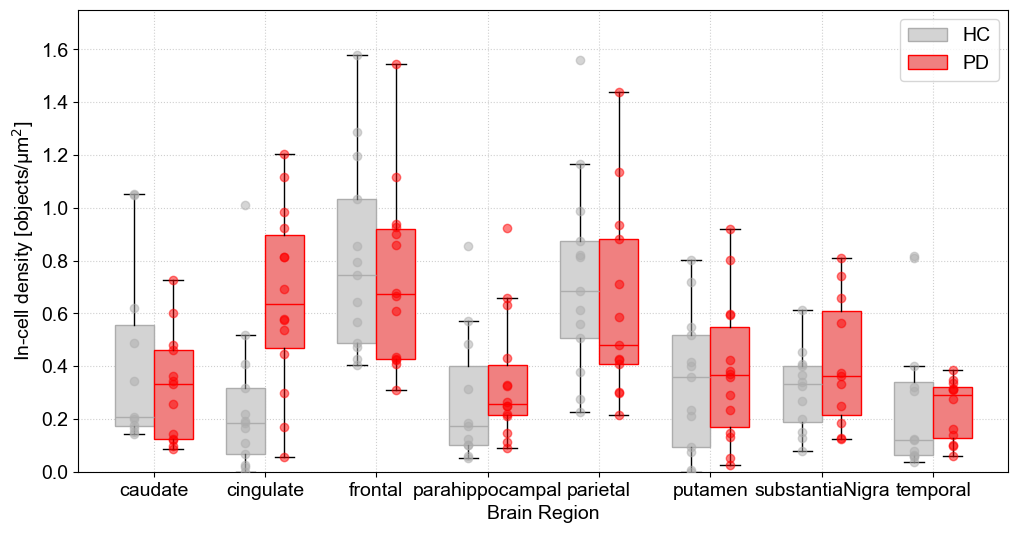

In [47]:
comb = pd.concat([df_hc, df_pd])

# Get unique cell types and regions
cell_types = comb['cell_type'].unique()
cell_types = ['microglia']
regions = comb['region'].unique()

# Iterate over each cell type and region to create and save scatter plots
for cell_type in cell_types:
    # Filter the dataframes for the current cell type
    hc_filtered = df_hc[(df_hc['cell_type'] == cell_type)]
    pd_filtered = df_pd[(df_pd['cell_type'] == cell_type)]
    
    if not hc_filtered.empty and not pd_filtered.empty:
        plt.figure(figsize=(12, 6))
        
        # Create positions for the box plots
        positions = np.arange(len(hc_filtered['region'].unique()))
        width = 0.35
        
        # Create box plots for HC data
        hc_data = []
        pd_data = []
        for thresh in hc_filtered['region'].unique():
            hc_data.append(hc_filtered[hc_filtered['region'] == thresh]['hc_mean'])
            pd_data.append(pd_filtered[pd_filtered['region'] == thresh]['pd_mean'])
        
        # Plot box plots
        bp_hc = plt.boxplot(hc_data, positions=positions-width/2, widths=width, 
                          patch_artist=True, boxprops=dict(facecolor='#d3d3d3', color='#adadad'),
                          medianprops=dict(color='#adadad'), showfliers=False)
        bp_pd = plt.boxplot(pd_data, positions=positions+width/2, widths=width, 
                          patch_artist=True, boxprops=dict(facecolor='lightcoral', color='red'),
                          medianprops=dict(color='red'), showfliers=False)
        
        # Plot individual points
        for i, thresh in enumerate(positions):
            hc_points = hc_filtered[hc_filtered['region'] == regions[i]]['hc_mean']
            pd_points = pd_filtered[pd_filtered['region'] == regions[i]]['pd_mean']
            
            plt.scatter(np.repeat(thresh-width/2, len(hc_points)), hc_points, 
                      color='#adadad', alpha=0.5, zorder=3)
            plt.scatter(np.repeat(thresh+width/2, len(pd_points)), pd_points, 
                      color='red', alpha=0.5, zorder=3)
        
        
        #plt.axhline(y=1, color='black', linestyle='--')
        plt.xlabel('Brain Region')
        plt.ylabel('In-cell density [objects/μm$^{2}$]')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.ylim(0, 1.75)

        
        # Set x-ticks
        plt.xticks(positions, [f'{x}' for x in hc_filtered['region'].unique()])
        
        # Create custom legend
        legend_elements = [Patch(facecolor='#d3d3d3', edgecolor='#adadad', label='HC'),
                        Patch(facecolor='lightcoral', edgecolor='red', label='PD')]
        plt.legend(handles=legend_elements)
        
        # Save the plot
        filename = f'{cell_type}_{region}_incell_density_across_intensity.svg'
        plt.savefig(filename, format='svg', dpi=800)
        plt.show()


In [ ]:
comb = pd.concat([df_hc, df_pd])

# Get unique cell types and regions
cell_types = comb['cell_type'].unique()
LPs = comb['LP'].unique()

# Iterate over each cell type and region to create and save scatter plots
for cell_type in cell_types:
    for LP in LPs:
        # Filter the dataframes for the current cell type and region
        hc_filtered = df_hc[(df_hc['cell_type'] == cell_type) & (df_hc['LP'] == LP)]
        pd_filtered = df_pd[(df_pd['cell_type'] == cell_type) & (df_pd['LP'] == LP)]
    
        plt.figure(figsize=(12, 6))
        
        # Create positions for the box plots
        positions = np.arange(len(hc_filtered['int_threshold'].unique()))
        width = 0.35
        
        # Create box plots for HC data
        hc_data = []
        pd_data = []
        for thresh in hc_filtered['int_threshold'].unique():
            hc_data.append(hc_filtered[hc_filtered['int_threshold'] == thresh]['hc_mean'])
            pd_data.append(pd_filtered[pd_filtered['int_threshold'] == thresh]['pd_mean'])
        
        # Plot box plots
        bp_hc = plt.boxplot(hc_data, positions=positions-width/2, widths=width, 
                            patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
                            medianprops=dict(color='blue'), showfliers=False)
        bp_pd = plt.boxplot(pd_data, positions=positions+width/2, widths=width, 
                            patch_artist=True, boxprops=dict(facecolor='lightcoral', color='red'),
                            medianprops=dict(color='red'), showfliers=False)
        
        # Plot individual points
        for thresh in positions:
            hc_points = hc_filtered[hc_filtered['int_threshold'] == thresh*10]['hc_mean']
            pd_points = pd_filtered[pd_filtered['int_threshold'] == thresh*10]['pd_mean']
            
            plt.scatter(np.repeat(thresh-width/2, len(hc_points)), hc_points, 
                        color='blue', alpha=0.5, zorder=3)
            plt.scatter(np.repeat(thresh+width/2, len(pd_points)), pd_points, 
                        color='red', alpha=0.5, zorder=3)
        
        
        #plt.axhline(y=1, color='black', linestyle='--')
        plt.title(f'{cell_type} in {LP}')
        plt.xlabel('Aggregate Intensity [Fraction]')
        plt.ylabel('In-cell Density [objects/μm$^{2}$]')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.ylim(0, 7)

        
        # Set x-ticks
        plt.xticks(positions, [f'{x/100:.1f}' for x in hc_filtered['int_threshold'].unique()])
        
        # Create custom legend
        legend_elements = [Patch(facecolor='lightblue', edgecolor='blue', label='HC'),
                        Patch(facecolor='lightcoral', edgecolor='red', label='PD')]
        plt.legend(handles=legend_elements)
        
        # Save the plot
        filename = f'{cell_type}_{LP}_incell_density_across_intensity_Braak.svg'
        #plt.savefig(filename, format='svg', dpi=800)
        plt.show()


In [ ]:
# Now plotting the proportion of high density cells with unified threshold for all regions















pd_ids = ['PD0822', 'PD0612','PD0086','PD0687','PD0596', 'PD0590', 'PD0913','PD0109', 'PD0980','PD0969','PD0945','PD0779', 'PD0022','PD0917']
hc_ids = ['C030','C043','C046','C073','C074','C075','C076','PDC022','PDC029','PDC034','PDC035','PDC085','PDC087']


which_thresh = 0 # Use 0 for combined PD & HC puncta-cell likelihood distributions 1.5 x and 1 for PD and HC separately thresholded to determine sick cells/healthy cells
meta = pd.read_csv(r'S:\ASAP_Imaging_Data\Main_Survey\oligomers_in_cells_additional_data\metadata.csv')


def cdf_output_individual(df_pd, df_hc, title, region, threshold, which_thresh):

    # Extract unique IDs from filenames
    if region == 'substantiaNigra':
        df_pd['id'] = df_pd['image_filename'].str.slice(103,111)
        df_hc['id'] = df_hc['image_filename'].str.slice(103,111)
        df_hc['donorid'] = df_hc['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
        df_pd['donorid'] = df_pd['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
    else:
        df_pd['id'] = df_pd['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['id'] = df_hc['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['donorid'] = df_hc['id'].map(meta.set_index('R_S_ID')['donorid'])
        df_pd['donorid'] = df_pd['id'].map(meta.set_index('R_S_ID')['donorid'])
   

    df_pd['area'] = df_pd['area/pixels']*0.0121
    df_pd['celldensity'] = df_pd['n_puncta_in_cell']/df_pd['area']
    df_hc['area'] = df_hc['area/pixels']*0.0121
    df_hc['celldensity'] = df_hc['n_puncta_in_cell']/df_hc['area']

    df_total = pd.concat([df_pd, df_hc], ignore_index=True)
    
    # Function to calculate counts above x sigma and errors
    def calculate_above_sigma(df, sigma_multiplier, df_total):
        mean = df['celldensity'].mean()
        std_dev = df['celldensity'].std()
        mean_total = df_total['celldensity'].mean()
        std_dev_total = df_total['celldensity'].std()
        
        if which_thresh == 0:
            threshold_calc = mean_total + sigma_multiplier * std_dev_total
        else:
            threshold_calc = mean + sigma_multiplier * std_dev  

        # Count values above the threshold
        total = df['celldensity'].count()
        
        # Count per individual
        individual_counts = df[df['celldensity'] > threshold_calc].groupby('donorid').size()
        total_individual = df['celldensity'].groupby(df['donorid']).size()

        # Count unique IDs above the threshold
        unique_id = df[df['celldensity'] > threshold_calc]['donorid'].nunique()

        # Calculate standard deviation for error bars
        std_error = individual_counts.std() if len(individual_counts) > 1 else 0

        return total, individual_counts, std_error, unique_id, total_individual 

    # Calculate for both dataframes
    total_pd, pd_ind, err_a, pd_unique_ids, total_pd_ind = calculate_above_sigma(df_pd, threshold, df_total)
    total_hc, hc_ind, err_b, hc_unique_ids, total_hc_ind = calculate_above_sigma(df_hc, threshold, df_total)

    hc_ind_2 = hc_ind
    pd_ind_2 = pd_ind
    total_pd_ind_2 = total_pd_ind
    total_hc_ind_2 = total_hc_ind

    # Remove values from total_pd_ind and total_hc_ind that are below or equal to 10
    total_pd_ind_2 = total_pd_ind_2[total_pd_ind_2 > 10]
    total_hc_ind_2 = total_hc_ind_2[total_hc_ind_2 > 10]

    # Remove matching ids from pd_ind and hc_ind
    pd_ind_2 = pd_ind_2[pd_ind_2.index.isin(total_pd_ind_2.index)]
    hc_ind_2 = hc_ind_2[hc_ind_2.index.isin(total_hc_ind_2.index)]

    pd_ind_2 = pd_ind_2.reindex(total_pd_ind_2.index, fill_value=0)
    hc_ind_2 = hc_ind_2.reindex(total_hc_ind_2.index, fill_value=0)

    # Remove values from total_pd_ind and total_hc_ind that are below or equal to 10
    total_pd_ind = total_pd_ind[total_pd_ind > 10]
    total_hc_ind = total_hc_ind[total_hc_ind > 10]

    # Remove matching ids from pd_ind and hc_ind
    pd_ind = pd_ind[pd_ind.index.isin(total_pd_ind.index)]
    hc_ind = hc_ind[hc_ind.index.isin(total_hc_ind.index)]

    pd_ids = ['PD0822', 'PD0612','PD0086','PD0687','PD0596', 'PD0590', 'PD0913','PD0109', 'PD0980','PD0969','PD0945','PD0779', 'PD0022','PD0917']
    hc_ids = ['C030','C043','C046','C073','C074','C075','C076','PDC022','PDC029','PDC034','PDC035','PDC085','PDC087']

    # Ensure all pd_ids are in pd_ind
    for pd_id in pd_ids:
        if pd_id not in pd_ind.index:
            pd_ind[pd_id] = 0
        if pd_id not in total_pd_ind.index:
            total_pd_ind[pd_id] = 0

    # Ensure all hc_ids are in hc_ind
    for hc_id in hc_ids:
        if hc_id not in hc_ind.index:
            hc_ind[hc_id] = 0
        if hc_id not in total_hc_ind.index:
            total_hc_ind[hc_id] = 0

    # Align indices of pd_ind and total_pd_ind
    pd_ind = pd_ind.reindex(total_pd_ind.index, fill_value=0)
    perc_pd = (pd_ind / total_pd_ind) * 100

    hc_ind = hc_ind.reindex(total_hc_ind.index, fill_value=0)
    perc_hc = (hc_ind / total_hc_ind) * 100

    # Fill NaN values with 0 of the newly added id's which did not have any cells in CPL
    perc_pd = perc_pd.fillna(0)
    perc_hc = perc_hc.fillna(0)
    pd_ind = pd_ind.fillna(0)
    hc_ind = hc_ind.fillna(0)

    pd_count = perc_pd.mean()
    hc_count = perc_hc.mean()
    pd_error = perc_pd.std()
    hc_error = perc_hc.std()

    individuals = perc_pd/hc_count
    out = pd.concat([perc_pd, perc_hc])
    
    # Calculate the ratio of PD/HC and propagate the error
    ratio_pd_hc = pd_count / hc_count

    error_pd_hc = ratio_pd_hc *(np.sqrt((pd_error / pd_count) ** 2 + (hc_error / hc_count) ** 2 - (2*(pd_error/pd_count)*(hc_error/hc_count)))) # This is the conservative error propagation including the cross term

    # Save the ratio and error in a new variable
    pd_hc_ratio_with_error = {'ratio': ratio_pd_hc, 'error': error_pd_hc, 'cell_type' : title, 'region' : region}

    return pd_hc_ratio_with_error, pd_ind_2, hc_ind_2, total_pd_ind_2, total_hc_ind_2, individuals, out


In [ ]:
# 20250115: Computing the data for varying int thresholds on the new int-thresholded datasheets with percentile qualifier
PD_over_HC = []
folder = r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells'
regions = os.listdir(folder)
cell_types = ['microglia', 'neurons']
#cell_types = ['microglia']                    ## Used for troubleshooting
#regions = ['substantiaNigra']                       ## Used for troubleshooting

def extract_number(filename):
    prefix = "threshold_percentile_"
    start = filename.find(prefix) + len(prefix)
    end = filename.find("_k_4_", start)
    return float(filename[start:end])

int_threshs = np.arange(0, 100, 1)  # Define the thresholds used to create the datasheets in the folders.
sigma_threshs = np.arange(0, 2, 0.5)

for region in regions:
    for i, cell_type in enumerate(cell_types):
        if os.path.isdir(os.path.join(folder, region, cell_type, patient_types[1])):
            PD_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[1]))
            PD_data_files = np.sort([x for x in PD_data_files if '_mincellsize_2000_' in x and 'k_4_outliersremoved' in x and '_combined_' in x and 'cell_protein_load' not in x and 'percentile' in x])
            numbers = np.array([extract_number(file) for file in PD_data_files])
            sorted_indices = np.argsort(numbers)
            PD_data_files = PD_data_files[sorted_indices]
            PD_data_files = [file for file in PD_data_files if extract_number(file) in int_threshs]
            if len(PD_data_files) == len(int_threshs):
                PD_data = {}
                for file in PD_data_files:
                    PD_data[file] = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[1], file))
            else:
                continue

            HC_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[0]))
            HC_data_files = np.sort([x for x in HC_data_files if '_mincellsize_2000_' in x and 'k_4_outliersremoved' in x and '_combined_' in x and 'cell_protein_load' not in x and 'percentile' in x])
            numbers = np.array([extract_number(file) for file in HC_data_files])
            sorted_indices = np.argsort(numbers)
            HC_data_files = HC_data_files[sorted_indices]
            HC_data_files = [file for file in HC_data_files if extract_number(file) in int_threshs]
            if len(HC_data_files) == len(int_threshs):
                HC_data = {}
                for file in HC_data_files:
                    HC_data[file] = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[0], file))
            else:
                continue

            for key, int_threshold in enumerate(int_threshs):
                for sig_threshold in sigma_threshs:
                    result, pd_ind, hc_ind, total_pd_ind, total_hc_ind, individuals, out = cdf_output_individual(PD_data[PD_data_files[key]], HC_data[HC_data_files[key]], cell_type, region, sig_threshold, which_thresh)
                    sumcells = sum(pd_ind) + sum(hc_ind)
                    for id, value in out.items():
                        PD_over_HC.append({
                            'donorid': id,
                            'perc_cells': value,
                            'cell_type': cell_type,
                            'region': region,
                            'sig_threshold': sig_threshold,
                            'int_threshold': int_threshold,
                            'sumcells': sumcells
                        })

dfa = pd.DataFrame([entry for entry in PD_over_HC if isinstance(entry, dict)])
dfa['sig_threshold'] = dfa['sig_threshold'].round(1)

In [ ]:
pd_ids = ['PD0822', 'PD0612','PD0086','PD0687','PD0596', 'PD0590', 'PD0913','PD0109', 'PD0980','PD0969','PD0945','PD0779', 'PD0022','PD0917']
hc_ids = ['C030','C043','C046','C073','C074','C075','C076','PDC022','PDC029','PDC034','PDC035','PDC085','PDC087']

# Create a new column "LP" based on conditions
dfa['LP'] = None
dfa.loc[dfa['region'].isin(['parietal', 'frontal']), 'LP'] = 'No Lewy pathology'
dfa.loc[dfa['region'].isin(['cingulate','temporal', 'parahippocampal']), 'LP'] = 'Mild Lewy pathology'
dfa.loc[dfa['region'].isin(['putamen', 'caudate','substantiaNigra']), 'LP'] = 'Moderate-severe Lewy pathology'

# For each cell type and region combination
for cell_type in cell_types:
    for region in regions:
        # Filter the dataframe for the current cell type and region
        filtered_df = dfa[(dfa['cell_type'] == cell_type) & (dfa['region'] == region) & (dfa['sig_threshold'] == 1.5)]
        
        if not filtered_df.empty:
            # Create separate dataframes for PD and HC
            pd_data = filtered_df[filtered_df['donorid'].isin(pd_ids)]
            hc_data = filtered_df[filtered_df['donorid'].isin(hc_ids)]
            
            fig = plt.figure(figsize=(6, 5))  
            ax = fig.add_subplot(111)

            # Calculate means and cell counts for each int_threshold
            pd_means = pd_data.groupby('int_threshold')['perc_cells'].mean()
            pd_cells = pd_data.groupby('int_threshold')['sumcells'].mean()
            hc_means = hc_data.groupby('int_threshold')['perc_cells'].mean()
            hc_cells = hc_data.groupby('int_threshold')['sumcells'].mean()

            # Plot scatter points with color mapping to cell count
            scatter_pd = ax.scatter(pd_means.index/100, pd_means.values, 
                                  c=pd_cells.values, cmap='Reds', 
                                  norm=LogNorm(vmin=1, vmax=max(pd_cells.max(), hc_cells.max())),
                                  label='PD')
            scatter_hc = ax.scatter(hc_means.index/100, hc_means.values, 
                                  c=hc_cells.values, cmap='Blues',
                                  norm=LogNorm(vmin=1, vmax=max(pd_cells.max(), hc_cells.max())),
                                  label='HC')
            
            # Add colorbars
            #cbar_pd = fig.colorbar(scatter_pd, ax=ax, location='right', label=f'PD {cell_type}')
            #cbar_pd.set_ticks([10**i for i in range(0, int(np.log10(max(pd_cells.max(), hc_cells.max())))+1)])
            
            # Add second colorbar for HC
            #cbar_hc = fig.colorbar(scatter_hc, ax=ax, location='right', label=f'HC {cell_type}')
            #cbar_hc.set_ticks([10**i for i in range(0, int(np.log10(max(pd_cells.max(), hc_cells.max())))+1)])
            
            # Adjust spacing for colorbars
            #plt.subplots_adjust(right=0.85)
            
            # Fit linear models for both groups
            for data, color, label_prefix in [(pd_data, '#8b0000', 'PD'), (hc_data, '#304674', 'HC')]:
                if not data.empty:
                    x_data = data['int_threshold']/100
                    y_data = data['perc_cells']
                    weights = data['sumcells']
                    
                    # Remove NaNs and infinite values
                    mask = np.isfinite(x_data) & np.isfinite(y_data) & np.isfinite(weights)
                    x_data = x_data[mask]
                    y_data = y_data[mask]
                    weights = weights[mask]
                    
                    # Add constant term and fit model
                    x_data_const = sm.add_constant(x_data)
                    model = sm.WLS(y_data, x_data_const, weights=weights)
                    results = model.fit()
                    
                    # Plot fit line and confidence interval
                    x_fit = np.linspace(x_data.min(), x_data.max(), 100)
                    y_fit = results.params[0] + results.params[1] * x_fit
                    
                    # Create label with fit formula and R-squared
                    fit_label = f'{label_prefix} fit: y = {results.params[0]:.2f} {results.params[1]:+.2f}x)'
                    plt.plot(x_fit, y_fit, color=color, label=fit_label)
                    
                    # Calculate confidence intervals
                    y_fit_upper = (results.params[0] + results.bse[0]) + (results.params[1] + results.bse[1]) * x_fit
                    y_fit_lower = (results.params[0] - results.bse[0]) + (results.params[1] - results.bse[1]) * x_fit
                    
                    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, 
                                   color=color, alpha=0.2)
            
            plt.ylim(0,16)
            plt.xlim(0,1)
            plt.title(f'{cell_type} in {region}')
            plt.xlabel('Oligomer Intensity [Fraction]')
            plt.ylabel('High aggregate-density cells [%]')
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.legend()
            
            # Save the plot
            filename = f'{cell_type}_{region}_InCellDens_PDvsHC_combined.svg'
            #plt.savefig(filename, format='svg', dpi=800)
            plt.show()


In [ ]:
# Now taking the identified cells above the threshold and plotting their distribution across different regions

In [ ]:
def getmax(df_hc,df_pd):
    max_value = max(df_hc['celldensity'].max(), df_pd['celldensity'].max())
    return max_value


def plot_histogram(ax, df_pd, df_hc, label_pd, label_hc, title, sigma_multiplier, which_thresh):
    if region == 'substantiaNigra':
        df_pd['id'] = df_pd['image_filename'].str.slice(103,111)
        df_hc['id'] = df_hc['image_filename'].str.slice(103,111)
        df_hc['donorid'] = df_hc['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
        df_pd['donorid'] = df_pd['id'].apply(lambda x: meta[meta['R_S_ID'].apply(lambda y: y in x)]['donorid'].values[0] if any(meta['R_S_ID'].apply(lambda y: y in x)) else None)
    else:
        df_pd['id'] = df_pd['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['id'] = df_hc['image_filename'].str.extract(r'_MS_(.*?)_SS')
        df_hc['donorid'] = df_hc['id'].map(meta.set_index('R_S_ID')['donorid'])
        df_pd['donorid'] = df_pd['id'].map(meta.set_index('R_S_ID')['donorid'])

    # Remove rows where puncta_cell_likelihood is NaN
    df_pd = df_pd.dropna(subset=['puncta_cell_likelihood'])
    df_hc = df_hc.dropna(subset=['puncta_cell_likelihood'])

    removed_pd = len(df_pd) - len(df_pd.dropna(subset=['puncta_cell_likelihood']))
    removed_hc = len(df_hc) - len(df_hc.dropna(subset=['puncta_cell_likelihood']))

    print(f'removed {removed_pd} NaNs from df_pd and {removed_hc} from df_hc')
    
    df_pd['area'] = df_pd['area/pixels']*0.0121
    df_pd['celldensity'] = df_pd['n_puncta_in_cell']/df_pd['area']
    df_hc['area'] = df_hc['area/pixels']*0.0121
    df_hc['celldensity'] = df_hc['n_puncta_in_cell']/df_hc['area']

    df_total = pd.concat([df_pd, df_hc], ignore_index=True)

    # Function to calculate counts above x sigma and errors
    def calculate_above_sigma(df, sigma_multiplier, df_total):
        mean = df['celldensity'].mean()
        std_dev = df['celldensity'].std()
        mean_total = df_total['celldensity'].mean()
        std_dev_total = df_total['celldensity'].std()
        
        if which_thresh == 0:
            threshold_calc = mean_total + sigma_multiplier * std_dev_total
        else:
            threshold_calc = mean + sigma_multiplier * std_dev  

        # per individual
        above = df[df['celldensity'] > threshold_calc]
        total_id = df['celldensity'].groupby(df['donorid']).size()
        above_id = above['celldensity'].groupby(above['donorid']).size()

        return df, above, total_id , above_id, threshold_calc

    df_pd, pd_above, pd_numbs_total, pd_numbs_above, threshold_calc = calculate_above_sigma(df_pd, sigma_multiplier, df_total)
    df_hc, hc_above, hc_numbs_total, hc_numbs_above, threshold_calc = calculate_above_sigma(df_hc, sigma_multiplier, df_total)

   # Generate histogram bin edges
    bin_edges = np.histogram_bin_edges(df_pd['celldensity'], bins='fd')   # Change bins = to apply different binning algorithm.
    bin_edges_a = np.histogram_bin_edges(df_hc['celldensity'], bins='fd')

    # Get counts for annotations
    n_pd = len(df_pd)
    n_pd = f"{n_pd:,}"
    n_hc = len(df_hc)
    n_hc = f"{n_hc:,}"
    
    # Plot histograms 
    ax.hist(df_pd['celldensity'], bins=bin_edges, density=True, color='#8b0000', alpha=0.5, label=f'PD ($\\it{{n}}$ = {n_pd})')
    ax.hist(df_hc['celldensity'], bins=bin_edges_a, density=True, color='#304674', alpha=0.5, label=f'HC ($\\it{{n}}$ = {n_hc})')
    
    # Calculate medians
    median_hc = df_hc['celldensity'].median()
    median_pd = df_pd['celldensity'].median()
    
    # Add vertical lines for the medians
    ax.axvline(median_hc, color='#304674', linestyle='dotted', label='HC Median')
    ax.axvline(median_pd, color='#8b0000', linestyle='dotted', label='PD Median')
    ax.axvline(threshold_calc, color='black', linestyle='-', label=f'Μ+({sigma_multiplier}*σ)')

    # Add grid, labels, and title
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.3, zorder=0)
    ax.set_xlabel('In-cell Density [objects/μm$^{2}$]', fontsize = 12, fontfamily = 'Arial')
    ax.set_ylabel('Probability Density', fontsize = 12, fontfamily = 'Arial')
    ax.legend(fontsize = 10)
    ax.set_title(title)


In [ ]:
PD_over_HC = []
folder = r'S:\ASAP_Imaging_Data\Main_Survey\20241105_oligomers_in_cells'
regions = [r for r in os.listdir(folder) if r != '.DS_Store']
cell_types = ['microglia', 'neurons']

int_threshs = np.arange(0,100,25)  
sigma_multiplier = 1.5
which_thresh = 0

for region in regions:
    # Create a figure with 4 rows (int_threshs) and 2 columns (cell types)
    fig, axs = plt.subplots(len(int_threshs), 2, figsize=(12, 20))
    
    # Dictionary to store max density per cell type
    max_density_by_type = {cell_type: 0 for cell_type in cell_types}
    
    # First pass to find maximum cell density for each cell type
    for i, cell_type in enumerate(cell_types):
        for j, int_thresh in enumerate(int_threshs):
            if os.path.isdir(os.path.join(folder, region, cell_type, patient_types[1])):
                # Get PD data
                PD_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[1]))
                PD_data_files = [x for x in PD_data_files if '_mincellsize_2000_' in x and 
                            'k_4_outliersremoved' in x and f'_combined_threshold_percentile_{int_thresh}_' in x and 
                            'cell_protein_load' not in x and 'percentile' in x]
                
                # Get HC data
                HC_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[0]))
                HC_data_files = [x for x in HC_data_files if '_mincellsize_2000_' in x and 
                            'k_4_outliersremoved' in x and f'_combined_threshold_percentile_{int_thresh}_' in x and 
                            'cell_protein_load' not in x and 'percentile' in x]
                
                if PD_data_files and HC_data_files:
                    # Load data
                    pd_data = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[1], PD_data_files[0]))
                    hc_data = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[0], HC_data_files[0]))
                    
                    # Calculate cell density
                    pd_data['area'] = pd_data['area/pixels']*0.0121
                    pd_data['celldensity'] = pd_data['n_puncta_in_cell']/pd_data['area']
                    hc_data['area'] = hc_data['area/pixels']*0.0121
                    hc_data['celldensity'] = hc_data['n_puncta_in_cell']/hc_data['area']
                    
                    # Update max density for this cell type
                    current_max = max(pd_data['celldensity'].max(), hc_data['celldensity'].max())
                    max_density_by_type[cell_type] = max(max_density_by_type[cell_type], current_max)
    
    # Second pass to create plots
    for i, cell_type in enumerate(cell_types):
        for j, int_thresh in enumerate(int_threshs):
            if os.path.isdir(os.path.join(folder, region, cell_type, patient_types[1])):
                # Get and load data (same as before)
                PD_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[1]))
                PD_data_files = [x for x in PD_data_files if '_mincellsize_2000_' in x and 
                            'k_4_outliersremoved' in x and f'_combined_threshold_percentile_{int_thresh}_' in x and 
                            'cell_protein_load' not in x and 'percentile' in x]
                
                HC_data_files = os.listdir(os.path.join(folder, region, cell_type, patient_types[0]))
                HC_data_files = [x for x in HC_data_files if '_mincellsize_2000_' in x and 
                            'k_4_outliersremoved' in x and f'_combined_threshold_percentile_{int_thresh}_' in x and 
                            'cell_protein_load' not in x and 'percentile' in x]
                
                if PD_data_files and HC_data_files:
                    pd_data = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[1], PD_data_files[0]))
                    hc_data = pd.read_csv(os.path.join(folder, region, cell_type, patient_types[0], HC_data_files[0]))
                    
                    # Plot histogram with cell-type specific x-axis limits
                    plot_histogram(axs[j,i], pd_data, hc_data, 'PD', 'HC', 
                                 f'{cell_type} - aggregates ≥ {int_thresh}% [intensity]', sigma_multiplier, which_thresh)
                    axs[j,i].set_xlim(0, max_density_by_type[cell_type])

    # Set overall title and adjust layout
    fig.suptitle(f'{region}', fontsize=20)
    plt.tight_layout()
    
    # Save figure
    filename = f'20250226_{region}_InCellDensity_hist_panel.svg'
    plt.savefig(filename, format='svg', dpi=800)
    plt.close()
